## State Summaries From Electricity Data

[Home Page](https://john-grando.github.io/)

In this analysis, we will explore the preprocessed data for the electricity dataset from the EIA bulk file download website.  This dataset contains information on the electrical generation statistics for U.S. plants.  With this formatted data, we can take easily aggregate data and provide some general summaries before taking a deeper dive.  Here we will focus on the fuel consumption by state and try to visualize some meaningful metrics from those attributes

### Initial Setup

In [1]:
import os, sys
import pprint as p
import pyspark.sql.functions as pysF
import pandas as pd
import plotly.express as px

py_file_path = os.path.join(
    os.getcwd(),
    "..",
    ".."
)

sys.path.append(py_file_path)
from app.SparkTools import MyPySpark

MySpark = None

#ensure only one sc and spark instance is running
global MySpark
MySpark = MySpark or MyPySpark(
    master = 'local[3]', 
    logger_name = 'jupyter')

In [2]:
# Graphing format functions
def treemap_fig_format(in_fig, title_text):
    """
    Provide standard formatting to treemap figures
    """
    return in_fig.update_layout(
    title = {
        "text" : title_text,
        "font" : {
            "size" : 20},
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })

There are a number of metrics that can be analyzed in this data set, but for this report we will focus on just a few.  Specifically, we will look at the net generation from fuel sources and customer account data to provide overall, and normalized, metrics.

## Net Generation

### Filter and Join Data

In [3]:
electricity_dim_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/ElectricityPlantLevelDimDF")\
    .filter(
        (pysF.col("series_id").rlike("^ELEC\.PLANT\.GEN\.")) &
        (pysF.lower(pysF.col("engine_type")) == 'all primemovers') &
        (pysF.col("f") == "M"))\
    .withColumn(
        "fuel_type",
        pysF.regexp_replace(
            pysF.regexp_replace(
                pysF.col("fuel_type"),
                "[^a-zA-Z0-9\s]", 
                ""),
            "\s",
            "_"))\
    .filter(pysF.col("iso3166").isNotNull())\
    .withColumn(
        "state",
        pysF.regexp_extract(
            pysF.col("iso3166"),
            r"^USA-([A-Z]+)",
            1))\
    .select("series_id", "state", "fuel_type", "engine_type", "units")\

electricity_fact_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/ElectricityFactDF")

electricity_df = electricity_fact_df.join(
    pysF.broadcast(electricity_dim_df),
    on = "series_id",
    how = "right"
)

### Format Data

In [4]:
#Pivot data and create an 'other' column that captures the 
#difference between total and the sum of the fuel_type categories
fuel_types_l = electricity_df\
    .select("fuel_type")\
    .distinct()\
    .rdd.map(lambda x: x[0])\
    .collect()

electricity_pivoted_summary_df = electricity_df\
    .groupBy("date", "state")\
    .pivot("fuel_type")\
    .agg(pysF.sum("value"))\
    .fillna(
        0, 
        subset=[i for i in fuel_types_l if i])\
    .drop("null")\
    .withColumn(
        "other",
        pysF.col("all_fuels") - sum(pysF.col(i) for i in fuel_types_l if i and i != "all_fuels"))

In [5]:
#Unpivot back to original format
electricity_formatted_df = MySpark.melt(
    df = electricity_pivoted_summary_df,
    id_vars = ["date", "state"],
    value_vars = [i for i in fuel_types_l if i and i != "all_fuels"],
    var_name = 'fuel_type')

### State Summaries

In [6]:
#Create state summary df for 2019
state_2019_df = electricity_formatted_df\
    .filter(
        (pysF.year("date") == "2019") & 
        (pysF.col("value") > 0))\
    .groupBy("state", "fuel_type")\
    .agg(pysF.sum("value").alias("generation"))\
    .withColumn("Net Generation", pysF.lit("Net Generation"))

#### Net Generation with State Subcategories

For a first look we can visualize how much generated electrcity came from each fuel type.  In the following plot, we visualize the 2019 consumption quantities for every plant in the U.S., aggregated by state.  Right away, we can see that there are some major fuel sources, (e.g. natural gas, nuclear, coal) as well as many smaller categories.  Note, you can click on individual boxes to zoom in on the data, and click on the outer box to zoom out.

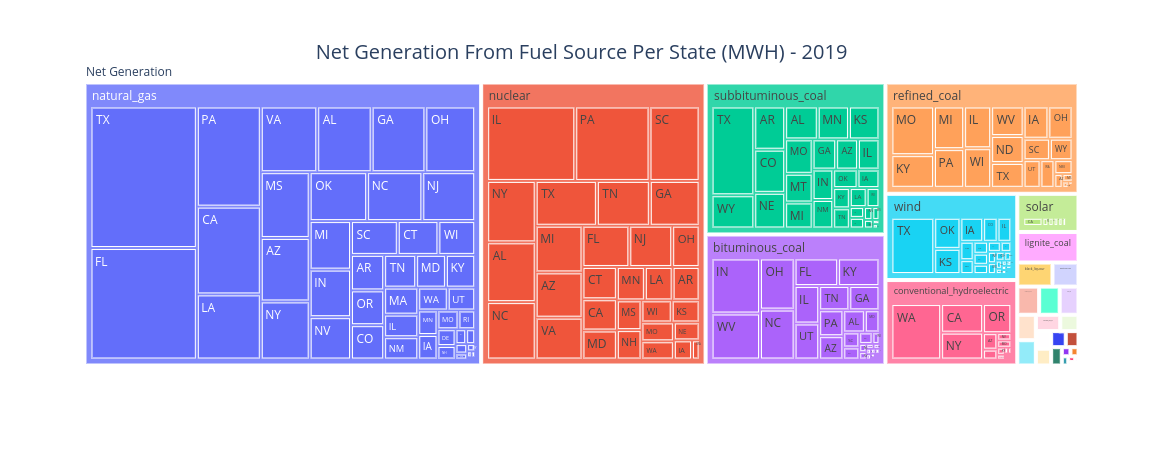

In [7]:
fig = px.treemap(
    data_frame = state_2019_df.toPandas(),
    names = "fuel_type",
    values = "generation",
    path = ["Net Generation", "fuel_type", "state"],
)
treemap_fig_format(
    fig, 
    title_text = "Net Generation From Fuel Source Per State (MWH) - 2019").show()

In order to simplify the dataset, we will collect all the coal and renewable categories into individual groups, as well as all the minor categories into an 'other' category.  Here we see a cleaner picture of the general fuel consumption.  Natural gas, coal, and nuclear are the predominant sources, and the primary consumers appear to be the larger states, like California and Texas.  Later on we will take a look at normalized consumption, but for now we will continue with the raw totals.

In [8]:
electricity_formatted_reduced_df = electricity_formatted_df\
    .withColumn(
        "fuel_type",
        pysF.when(
            pysF.col("fuel_type").rlike(".*_coal$"),
            "coal")\
        .otherwise(
            pysF.when(
                (pysF.col("fuel_type").isin([
                    "geothermal",
                    "solar",
                    "wind"])) |
                (pysF.col("fuel_type").rlike(".*hydroelectric.*")), 
                "renewable")
            .otherwise(
                pysF.when(
                    pysF.col("fuel_type").isin(["natural_gas","nuclear"]), 
                    pysF.col("fuel_type"))
                .otherwise("other"))))
    
electricity_formatted_reduced_df.cache()

state_2019_reduced_df = electricity_formatted_reduced_df\
    .filter(
        (pysF.year("date") == "2019") & 
        (pysF.col("value") > 0))\
    .groupBy("state", "fuel_type")\
    .agg(pysF.sum("value").alias("generation"))\
    .withColumn("Net Generation", pysF.lit("Net Generation"))

state_2019_reduced_df.cache()

DataFrame[state: string, fuel_type: string, generation: double, Net Generation: string]

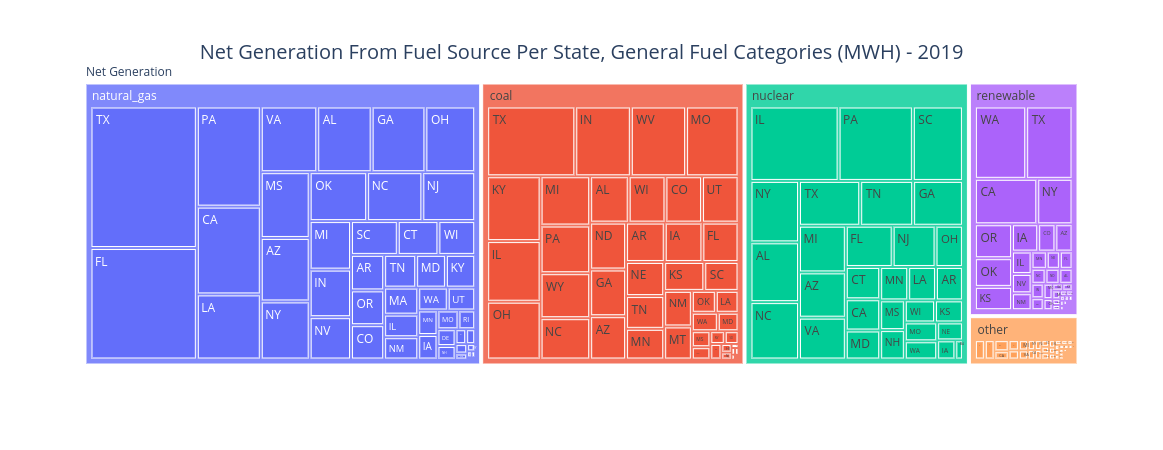

In [9]:
fig = px.treemap(
    data_frame = state_2019_reduced_df.toPandas(),
    names = "fuel_type",
    values = "generation",
    path = ["Net Generation", "fuel_type", "state"]
)

treemap_fig_format(
    fig, 
    title_text = "Net Generation From Fuel Source Per State, General Fuel Categories (MWH) - 2019").show()

#### State Categories with Fuel Source Subcategories

We can take a quick look at the converse treempap which groups the consumption by state, then fuel source.  One interesting concept here is that most states have a mixture of the 'big three' fuel sources (natural gas, coal, nuclear), adn almost no states rely totally one one type of fuel.

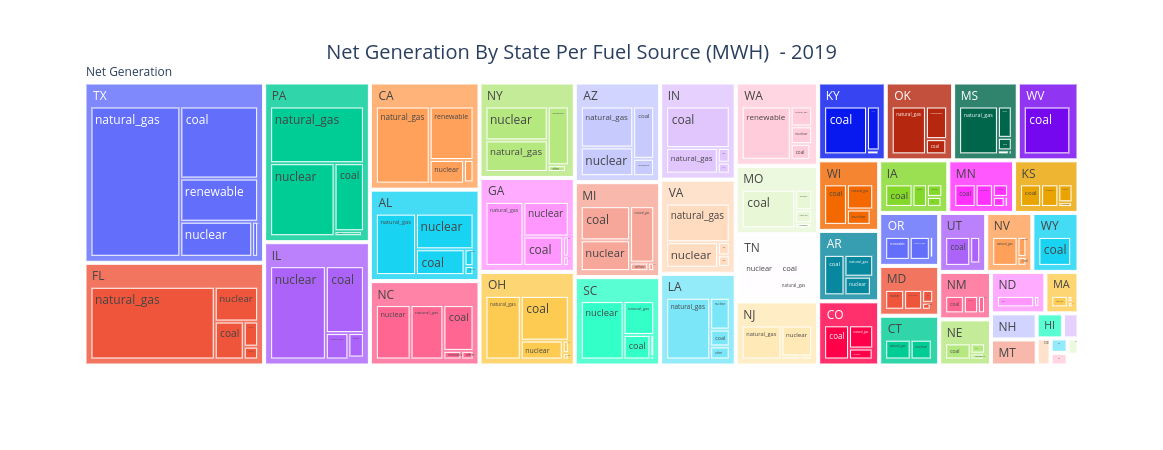

In [10]:
fig = px.treemap(
    data_frame = state_2019_reduced_df.toPandas(),
    names = "fuel_type",
    values = "generation",
    path = ["Net Generation", "state", "fuel_type"]
)
treemap_fig_format(
    fig, 
    title_text = "Net Generation By State Per Fuel Source (MWH)  - 2019").show()

Evaluating the totals is useful; however, it is also useful to see how the fuel consumptions change over time.  For this next plot, we will compare the current year (in this case 2019) to averages of previous years.  In order to smooth the data, and avoid comparing any off-years, we will get the difference of the current five year average (i.e. 2015 - 2019) and compare it to the previous 5 year average (i.e. 2010 - 2014).

In [11]:
from pyspark.sql.window import Window as pysW
# 5 year average centered at 5 years ago
state_fuel_5_year_windowspec = pysW\
    .partitionBy("state", "fuel_type")\
    .orderBy("year")\
    .rowsBetween(-9, -5)

state_fuel_3_prev_year_windowspec = pysW\
    .partitionBy("state", "fuel_type")\
    .orderBy("year")\
    .rowsBetween(-4, pysW.currentRow)

In [12]:
state_consumption_diff_df = electricity_formatted_reduced_df\
    .withColumn(
        "year",
        pysF.year("date"))\
    .groupBy(
        "year",
        "state", 
        "fuel_type")\
    .agg(pysF.sum("value").alias("generation"))\
    .withColumn(
        "generation_diff",
        pysF.avg(pysF.col("generation")).over(state_fuel_3_prev_year_windowspec) - 
        pysF.avg(pysF.col("generation")).over(state_fuel_5_year_windowspec))\
    .orderBy("state", "fuel_type", "year")

state_2019_diff_reduced_increase_df = state_consumption_diff_df\
    .select("year", "state", "fuel_type", "generation_diff")\
    .filter(
        (pysF.col("year") == "2019") & 
        (pysF.col("generation_diff").isNotNull()) &
        (pysF.col("generation_diff")>0))\
    .withColumn("Net Generation", pysF.lit("Net Generation"))

state_2019_diff_reduced_decrease_df = state_consumption_diff_df\
    .select("year", "state", "fuel_type", "generation_diff")\
    .filter(
        (pysF.col("year") == "2019") & 
        (pysF.col("generation_diff").isNotNull()) &
        (pysF.col("generation_diff")<0))\
    .withColumn(
        "generation_diff",
        pysF.col("generation_diff") * -1)\
    .withColumn("Net Generation", pysF.lit("Net Generation"))

First we can take a look at the net generation that increased from the previous period to now and see how that relates to the fuel sources used to create the energy.  It is evident that there has been a large increase in natural gas and renwable consumption, with nuclear power following behind.

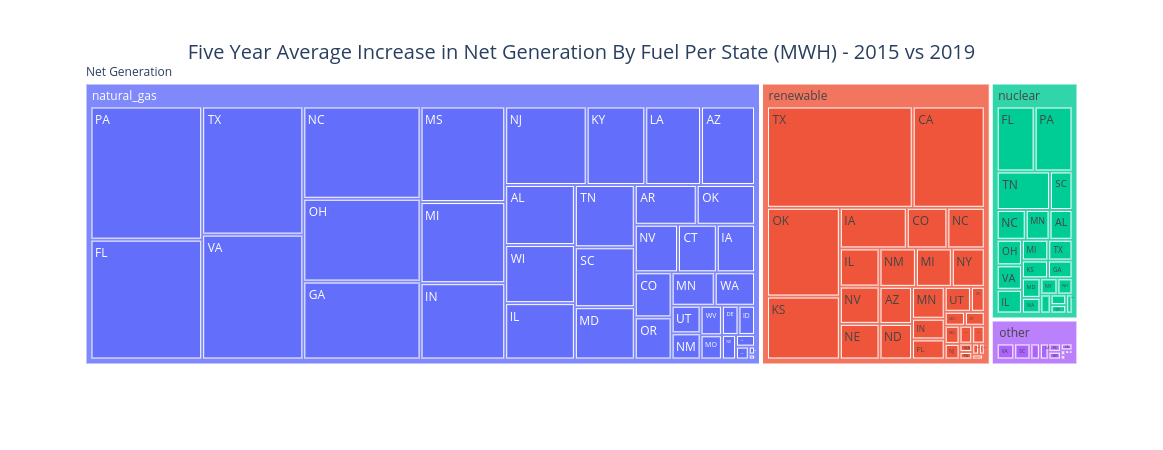

In [13]:
fig = px.treemap(
    data_frame = state_2019_diff_reduced_increase_df.toPandas(),
    names = "fuel_type",
    values = "generation_diff",
    path = ["Net Generation", "fuel_type", "state"]
)

treemap_fig_format(
    fig, 
    title_text = "Five Year Average Increase in Net Generation By Fuel Per State (MWH) - 2015 vs 2019").show()

In the plot of decreasing consumption values, the major fuel source being reduced is coal.

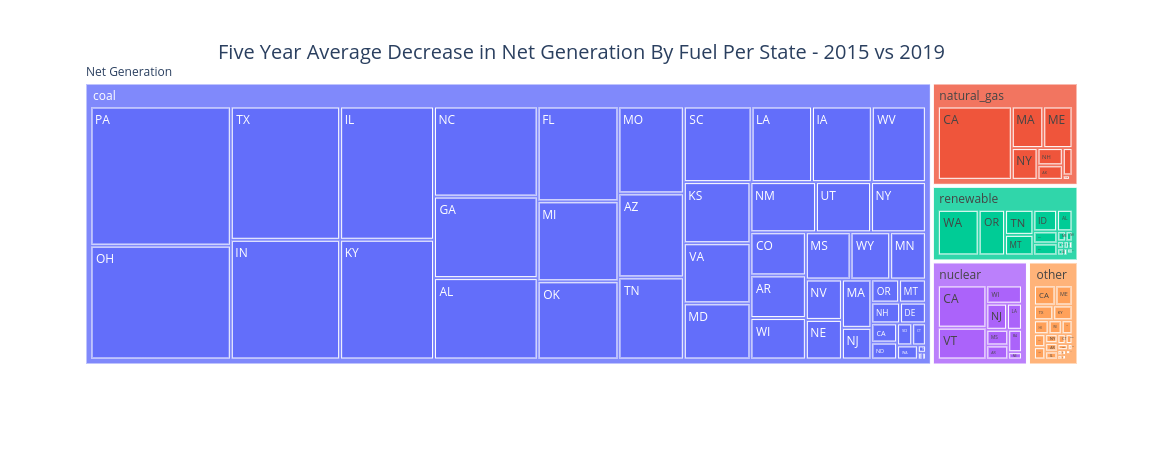

In [14]:
fig = px.treemap(
    data_frame = state_2019_diff_reduced_decrease_df.toPandas(),
    names = "fuel_type",
    values = "generation_diff",
    path = ["Net Generation", "fuel_type", "state"]
)

treemap_fig_format(
    fig, 
    title_text = "Five Year Average Decrease in Net Generation By Fuel Per State - 2015 vs 2019").show()

## Normalized Consumption by Customer Account

In [15]:
customer_dim_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/ElectricityRetailDimDF")\
    .filter(
        (pysF.col("series_id").rlike("^ELEC\.CUSTOMERS\.")) &
        (pysF.col("sector") == "all sectors") &
        (pysF.col("iso3166").isNotNull()) &
        (pysF.col("f") == "M"))\
    .withColumn(
        "state",
        pysF.regexp_extract(
            pysF.col("iso3166"),
            r"^USA-([A-Z]+)",
            1))\
    .select("series_id", "state")

customer_fact_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/ElectricityFactDF")

customer_df = customer_fact_df.join(
    pysF.broadcast(customer_dim_df),
    on = "series_id",
    how = "right")\
    .withColumnRenamed("value", "customers")

### Join And Clean Customer Data

First, we will check to make sure that the customer account data is complete enough to join on the above net generation data.  From the preliminary check we can see that the latest year, for any state, containing nulls is 2016.  In fact, only one state has null data for 2016, which is Arkansas.  Given the small amount of missing data, we can we can do our own method of using a straight line between the two endpoints of missing cells without making any complex functions.

In [32]:
electricity_customer_df = electricity_formatted_reduced_df.join(
    customer_df,
    on = ["state", "date"],
    how = "left")\
    .withColumn(
        "year",
        pysF.year(pysF.col("date")))

electricity_customer_df\
    .groupBy(["year", "state"])\
    .agg(pysF.sum(pysF.col("customers").isNull().cast("integer")).alias("null_count"))\
    .filter(
        (pysF.col("null_count") > 0) &
        (pysF.col("year") < 2020)
    )\
    .orderBy(pysF.col("year").desc())\
    .limit(10)\
    .toPandas()\
    .head()

467415
467415


year state  null_count
0  2016    AK         468
1  2007    OH         468
2  2007    IL         468
3  2007    CT         468
4  2007    WA         468

In [17]:
max_ak_2016 = float(
    max(
        customer_df\
        .filter(
            (pysF.col("state") == "AK") &
            (pysF.year("date") == 2015))\
        .rdd\
        .map(lambda x : x["customers"])\
        .collect()))

min_ak_2017 = float(
    min(
        customer_df\
        .filter(
            (pysF.col("state") == "AK") &
            (pysF.year("date") == 2017))\
        .rdd\
        .map(lambda x : x["customers"])\
        .collect()))

electricity_customer_df = electricity_customer_df\
    .withColumn(
        "customers",
        pysF.when(
            ((pysF.col("state") == "AK") &
            (pysF.year("date") == 2016)),
            ((min_ak_2017-max_ak_2016)/13 * pysF.month(pysF.col("date")) + max_ak_2016))\
        .otherwise(pysF.col("customers")).cast("integer"))\
    .filter(pysF.year("date") > 2007)

electricity_customer_df.cache()

DataFrame[state: string, date: date, fuel_type: string, value: double, series_id: string, customers: int, year: int]

Now, we can do a simple join to create replacement values for missing data.  We can do a quick output check and see that sensible values have been imputed into the null fields and that the dataframe, in the original format, now shows no missing data (2007 and previous years have been removed).

In [18]:
electricity_customer_df\
    .filter(
        (pysF.col("state") == "AK") & 
        (pysF.col("year").isin([2015, 2016, 2017])))\
    .groupBy(["date"])\
    .agg(pysF.avg(pysF.col("customers")).alias("customers"))\
    .withColumn(
        "year",
        pysF.year(pysF.col("date")))\
    .withColumn(
        "month_day",
        pysF.concat_ws(
            "-",
            pysF.lpad(pysF.month(pysF.col("date")),2, "0"), 
            pysF.lpad(pysF.dayofmonth(pysF.col("date")), 2, "0")))\
    .groupBy(["month_day"])\
    .pivot("year")\
    .agg(pysF.avg(pysF.col("customers")).alias("cutomers"))\
    .limit(12)\
    .orderBy("month_day")\
    .toPandas()

month_day      2015      2016      2017
0      01-01  331677.0  336446.0  338282.0
1      02-01  331668.0  336599.0  338307.0
2      03-01  332583.0  336752.0  339073.0
3      04-01  333387.0  336905.0  339129.0
4      05-01  333680.0  337058.0  340120.0
5      06-01  334411.0  337211.0  341092.0
6      07-01  334993.0  337364.0  341026.0
7      08-01  335469.0  337517.0  342212.0
8      09-01  336042.0  337670.0  341820.0
9      10-01  336294.0  337823.0  342470.0
10     11-01  335076.0  337976.0  341618.0
11     12-01  335380.0  338129.0  341354.0

In [111]:
electricity_customer_df\
    .groupBy(["year", "state"])\
    .agg(pysF.sum(pysF.col("customers").isNull().cast("integer")).alias("null_count"))\
    .filter(
        (pysF.col("null_count") > 0) &
        (pysF.col("year") < 2020))\
    .orderBy(pysF.col("year").desc())\
    .limit(10)\
    .toPandas()\
    .head()

year state  null_count
0  2016    AK         468
1  2007    OH         468
2  2007    IL         468
3  2007    CT         468
4  2007    GA         468

So now we can normalize the metrics by dividing the state-wide generation values by the total number of customers for each fuel.  This will provide values expressed in kWH per customer account and provide a clearer picture when it comes to comparing states to each other

In [114]:
state_customer_windowspec = pysW\
    .partitionBy("state")

electricity_customer_normalized_df = electricity_customer_df\
    .groupBy(["year", "state", "fuel_type"])\
    .agg(
    (pysF.sum(pysF.col("value")) * 1000 / pysF.avg(pysF.first(pysF.col("customers"))).over(state_customer_windowspec)).alias("kWH_per_account"))\
    .withColumn("Net Generation", pysF.lit("Net Generation"))

electricity_customer_normalized_2019_df = electricity_customer_normalized_df\
        .filter(
            (pysF.col("year") == 2019) &
            (pysF.col("kWH_per_account") > 0))

electricity_customer_normalized_2019_df.cache()

DataFrame[year: int, state: string, fuel_type: string, kWH_per_account: double, Net Generation: string]

Befofe we get too far ahead of ourselves, we should check that the transformation is actually correct.  Some simple aggregations reveal that the overall summed `kWH_per_customer` multiplied by the total number of `customers` for 2019 is approximately 386,540,513,612 MWH, which is close to the 3,585,426,657 MWH reported in the overall analysis.

In [115]:
gen_per_account = sum(electricity_customer_normalized_2019_df.select("kWH_per_account").rdd.map(lambda x:x[0]).collect())

total_customers = sum(customer_df\
           .filter(pysF.year(pysF.col("date")) == 2019)\
           .groupBy("state")\
           .agg(pysF.avg(pysF.col("customers")).alias("customers")).select("customers").rdd.map(lambda x:x[0]).collect())

total_generation = sum(state_2019_reduced_df.select("generation").rdd.map(lambda x:x[0]).collect())
print(total_customers)
print('Generation per account (MWH): {:n}'.format(gen_per_account / 1000))
print('Generation per account from state summary (MWH): {:n}'.format(total_generation / total_customers))

309651726.8333334
Generation per account (MWH): 1303.57
Generation per account from state summary (MWH): 11.5789


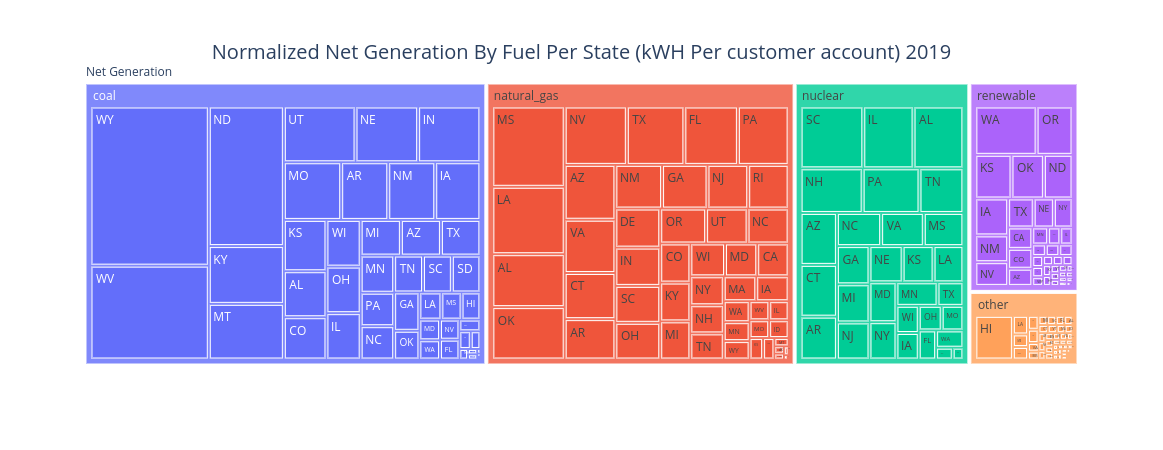

In [57]:
fig = px.treemap(
    data_frame = electricity_customer_normalized_2019_df.toPandas(),
    names = "fuel_type",
    values = "kWH_per_account",
    path = ["Net Generation", "fuel_type", "state"])

treemap_fig_format(
    fig, 
    title_text = "Normalized Net Generation By Fuel Per State (kWH Per customer account) 2019").show()

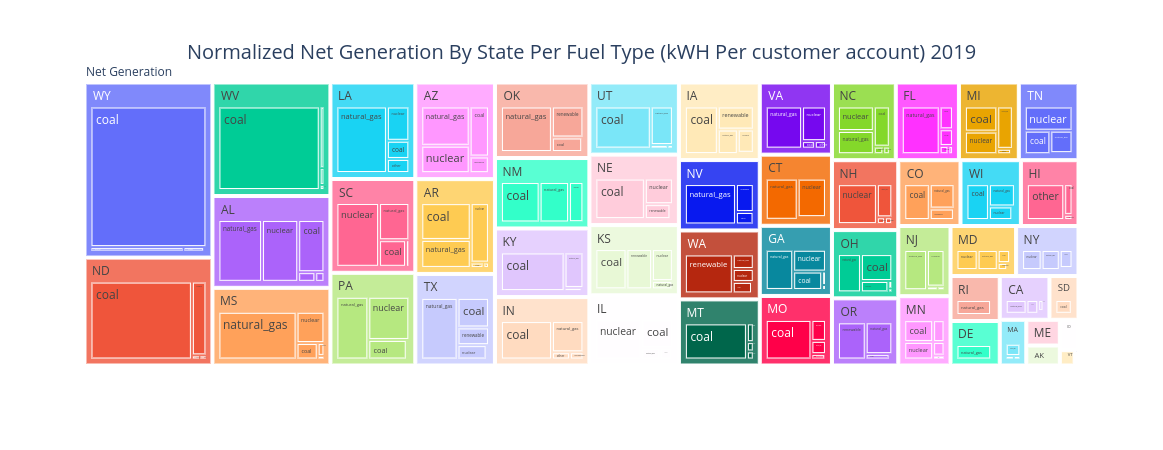

In [59]:
fig = px.treemap(
    data_frame = electricity_customer_normalized_2019_df.toPandas(),
    names = "fuel_type",
    values = "kWH_per_account",
    path = ["Net Generation", "state", "fuel_type"])

treemap_fig_format(
    fig, 
    title_text = "Normalized Net Generation By State Per Fuel Type (kWH Per customer account) 2019").show()

While not all customer accounts are the same, it is a first attempt at normalization.  In fact, we can see some interesting results here.  First, net generation per customer account from coal is the largest group in the fuel type grouping summary.  In the state grouping sumary we see that the largest net generation per customer account belongs to Wyoming, West Virginia, and North Dakota; all of which are predominantly coal consumers.

Additionally, it is interesting to find out that only three (WY, WV, KY) of the five biggest states that mine [coal](https://www.eia.gov/energyexplained/coal/where-our-coal-comes-from.php) (WY, WV, PA, IL, KY) use it as the primary fuel for generation. 

In [95]:
state_generations_windowspec = pysW\
    .partitionBy("state")

electricity_customer_ratios_2019_df = electricity_customer_normalized_2019_df\
    .withColumn(
        "fuel_ratio",
        pysF.col("kWH_per_account") / pysF.sum(pysF.col("kWH_per_account")).over(state_generations_windowspec))

state_ratio_windowspec = pysW\
    .partitionBy("state")\
    .orderBy(pysF.col("fuel_ratio").desc())

state_primary_coal_2019_df = electricity_customer_ratios_2019_df\
    .withColumn(
        "primary_fuel_type",
        pysF.first("fuel_type").over(state_ratio_windowspec))\
    .filter(
        (pysF.col("fuel_type") == pysF.col("primary_fuel_type")) &
        (pysF.col("primary_fuel_type") == pysF.lit("coal")))

With a little additional work, we can visualize the states which use coal as the primary source of generated electricity, and by how much.  Pennsylvania doesn't use coal as the primary source of net generation, but the remaining major coal mining states do.  It appears that whether or not a state mainly uses coal is a regional factor, but further analysis would be required.

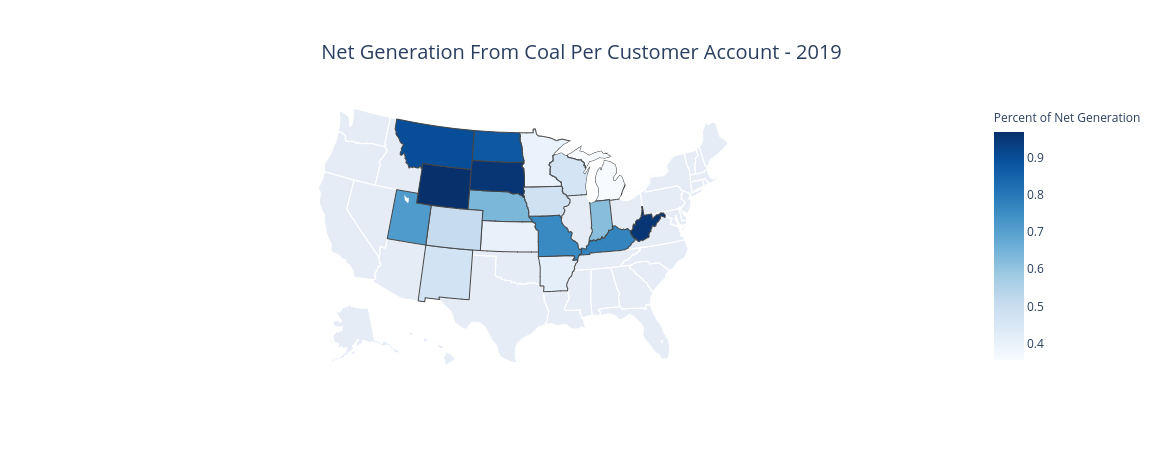

In [99]:
import plotly.graph_objects as go

chor_df = state_primary_coal_2019_df\
    .toPandas()

fig = go.Figure(data=go.Choropleth(
    locations=chor_df["state"], # Spatial coordinates
    z = chor_df["fuel_ratio"].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Percent of Net Generation",
))

fig.update_layout(
    geo_scope='usa', # limite map scope to USA
)

treemap_fig_format(fig, title_text = 'Net Generation From Coal Per Customer Account - 2019').show()

For fun, let's also plot the states where the primary generation came from natural gas and nuclear power.

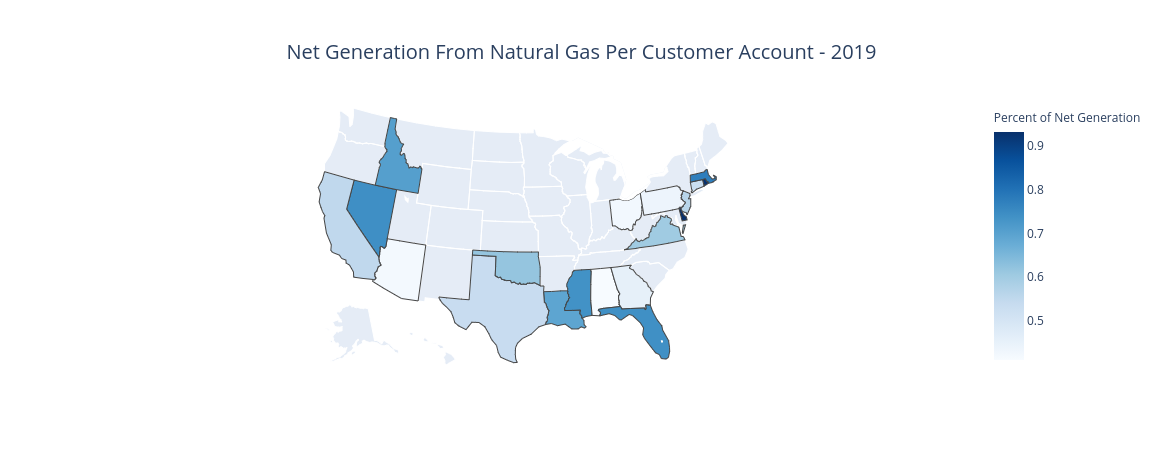

In [101]:
state_primary_ng_2019_df = electricity_customer_ratios_2019_df\
    .withColumn(
        "primary_fuel_type",
        pysF.first("fuel_type").over(state_ratio_windowspec))\
    .filter(
        (pysF.col("fuel_type") == pysF.col("primary_fuel_type")) &
        (pysF.col("primary_fuel_type") == pysF.lit("natural_gas")))

chor_df = state_primary_ng_2019_df\
    .toPandas()

fig = go.Figure(data=go.Choropleth(
    locations=chor_df["state"], # Spatial coordinates
    z = chor_df["fuel_ratio"].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Percent of Net Generation",
))

fig.update_layout(
    geo_scope='usa', # limite map scope to USA
)

treemap_fig_format(fig, title_text = 'Net Generation From Natural Gas Per Customer Account - 2019').show()

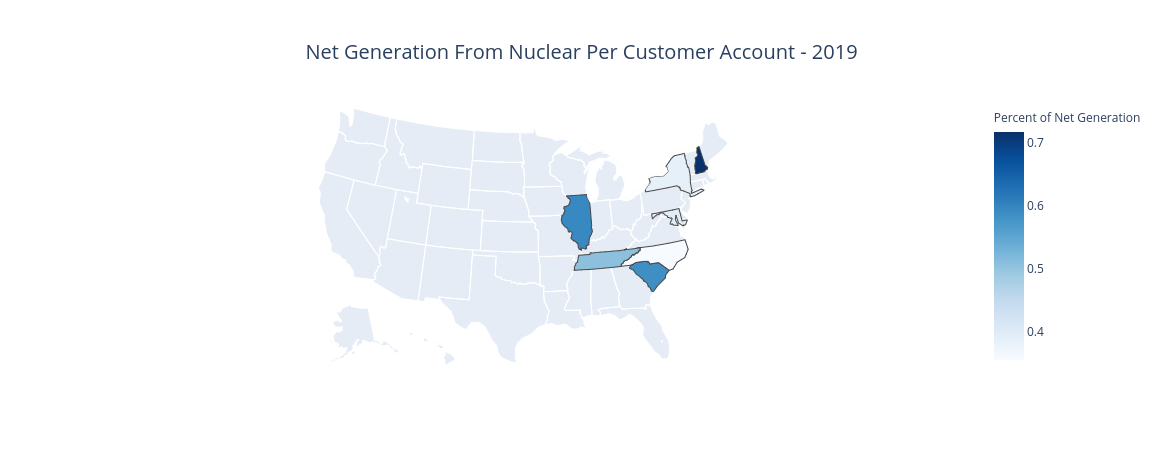

In [102]:
state_primary_nuclear_2019_df = electricity_customer_ratios_2019_df\
    .withColumn(
        "primary_fuel_type",
        pysF.first("fuel_type").over(state_ratio_windowspec))\
    .filter(
        (pysF.col("fuel_type") == pysF.col("primary_fuel_type")) &
        (pysF.col("primary_fuel_type") == pysF.lit("nuclear")))

chor_df = state_primary_nuclear_2019_df\
    .toPandas()

fig = go.Figure(data=go.Choropleth(
    locations=chor_df["state"], # Spatial coordinates
    z = chor_df["fuel_ratio"].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Percent of Net Generation",
))

fig.update_layout(
    geo_scope='usa', # limite map scope to USA
)

treemap_fig_format(fig, title_text = 'Net Generation From Nuclear Per Customer Account - 2019').show()

### Summary

We have learned that natural gas is the primary fuel source for the U.S, and that larger states, in terms of net generation, do not typically rely on a single fuel source.  Also, coal is the fuel source that is on the largest decline over the last five years and it appears to be replaced mostly by natural gas and renewables.  When we try to normalize the data by customer accounts, we see that coal is the primary fuel source for net generation per customer, which indicates it might be used by heaver consumers.  When we look at the data we also see that some states


plant level data